## How stock_helpers.py's Functions Work

### By: Trinity Lee

In [3]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing the libraries


In [4]:
import matplotlib.pyplot as plt
from stock_plot import StockPlot
import pandas as pd
import numpy as np

import pmdarima as pm



### How the Code works
We'll be web scraping the closing prices of a stock on a given day. From here on out any time "raw stock data" is referenced, we mean the unchanged value of the closing prices of a stock, without normalization or any other additional calculations. 

The first thing we can do is set the range of dates we want to scrape. We *could* choose when Tesla first IPOs to current date, but there is a more targeted approach to deciding the range of dates. It was only in 2013 that Tesla had its first profitable quarter, meaning that from it's IPO date to 2013, it's stock prices would be more affected by it's status as an high risk startup investment that wasn't making profits and this tweets. Furthermore, given that his account became verified by Twitter only in 2012, it's safe to assume 2010-2013 were years where Tesla's stock prices and Musk's tweets did not have high correlation. Hence, choosing to start from 2014 to the present date would be the best range of dates we want to scrape from.  

In [5]:
start_date = "2014-01-01"
end_date = "2023-2-28"

## Comparing Tesla 

### Market Indexes
Next, for each company/index stock, we create an StockPlot object for them and put then in a list. This allows our data to be organized. The different methods associated with the each StockPlot object allows us to get different permutations of our raw stock data.  

You notice quickly that plotting the Indexes vs the Tesla stocks on one graph lead to a useless graph because the Nasdaq index's prices are so much larger than the Tesla's stock. To compare the behavior, we can scale the prices through normalization via the sci kit library which reduces all the values to between 0-1 while preserving the overall behavior/weight of each closing price on that given day. 

### Companies/EV specific

Electric Vehicles (EV) have only become popular in the recent years. In fact, 2013 was when Tesla made its first quarterly profit, and it took until 2021 for the company to have its first profitable year. With these statistics in mind, EVs are still relatively recent, and thus not a lot of data is available on Tesla's direct competitors with the IPO dates being in only in the last several years. 

We can then want to look at Tesla in the context of the Overall EV market. The Global X Autonomous & Electric Vehicles ETF (DRIV) includes companies involved in the development of autonomous vehicle software and hardware, as well as companies that produce EVs, EV components such as lithium batteries, and critical EV materials such as lithium and cobalt. This is ETF would be a better reference than an individual EV competitor, such as Rivian, which lacks data. 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


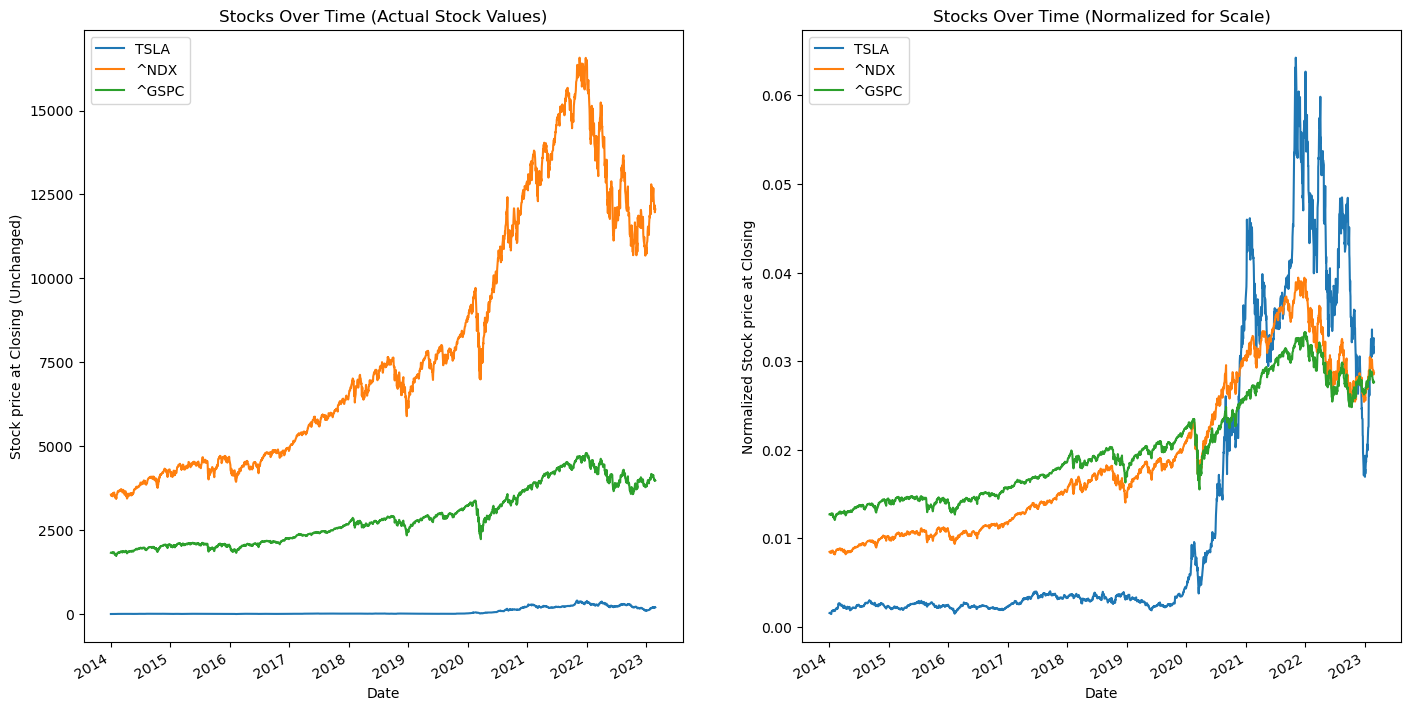

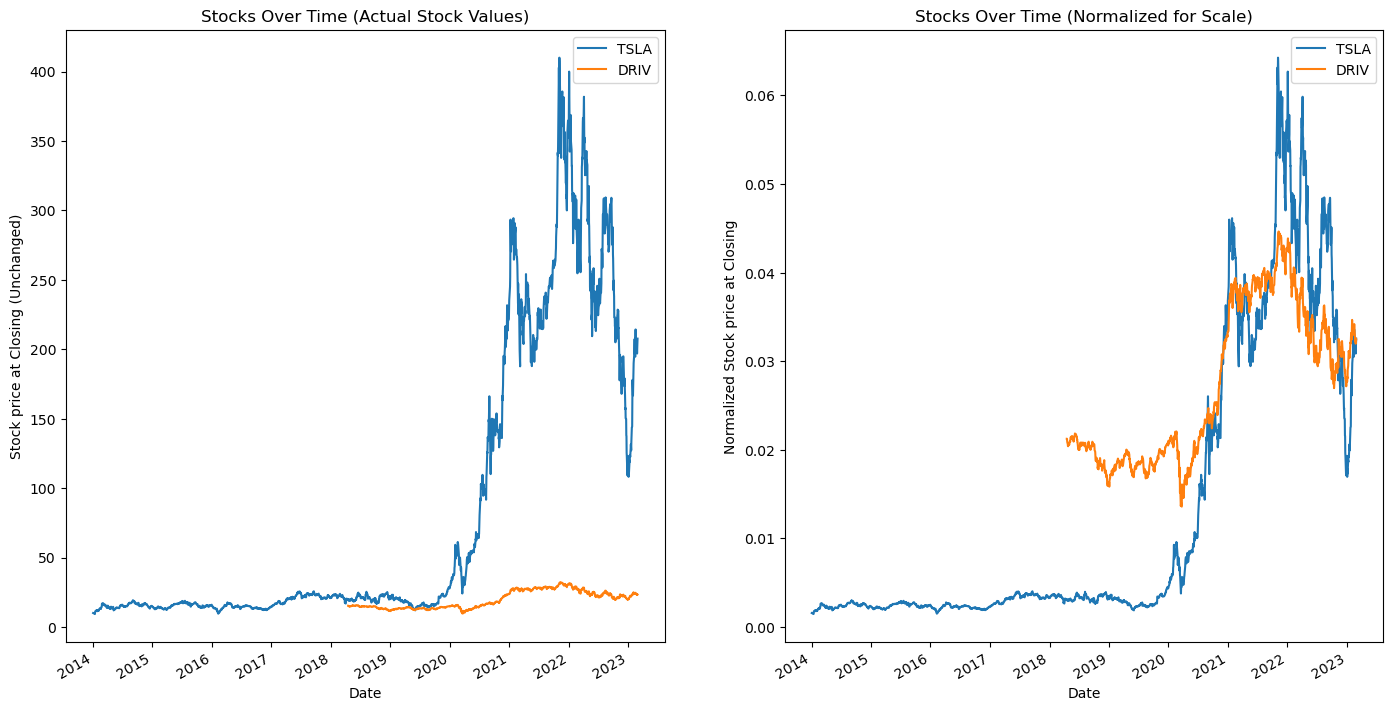

In [6]:
# Creating StockPlot Objects
tesla = StockPlot("TSLA", start_date, end_date)
nasdaq = StockPlot("^NDX", start_date, end_date)
sp500 = StockPlot("^GSPC", start_date, end_date)
ev_etf = StockPlot("DRIV", start_date, end_date)


#Storage for organization & easy plotting
market_list = [tesla, nasdaq,sp500]
ev_list = [tesla, ev_etf]
all_list = [tesla, nasdaq, sp500, ev_etf]

#Settings for the graph dimensions
fig, axes = plt.subplots(2, 1, figsize=(17,9))

#SubPlot 1: Raw Closing Stock Prices
plt.subplot(1, 2, 1)
for symbol in market_list:
    symbol.get_stock_data().plot(label=symbol.get_ticker())
    
plt.ylabel("Stock price at Closing (Unchanged)")
plt.title("Stocks Over Time (Actual Stock Values)")
plt.legend()

#SubPlot 2: Normalized Closing Stock Prices
plt.subplot(1, 2, 2)
for symbol in market_list:
    symbol.get_normalized_data().plot(label=symbol.get_ticker())

plt.ylabel("Normalized Stock price at Closing")
plt.title("Stocks Over Time (Normalized for Scale)")
plt.legend()
plt.show()




#Plotting Tesla vs EV ETF

fig, axes = plt.subplots(2, 1, figsize=(17,9))

plt.subplot(1, 2, 1)
for symbol in ev_list:
    symbol.get_stock_data().plot(label=symbol.get_ticker())
    
plt.ylabel("Stock price at Closing (Unchanged)")
plt.title("Stocks Over Time (Actual Stock Values)")
plt.legend()

#SubPlot 2: Normalized Closing Stock Prices

plt.subplot(1, 2, 2)
for symbol in ev_list:
    symbol.get_normalized_data().plot(label=symbol.get_ticker())

plt.ylabel("Normalized Stock price at Closing")
plt.title("Stocks Over Time (Normalized for Scale)")
plt.legend()
plt.show()



### Plotting Basic Time Series

While Figure 1 illustrates that the Nasdaq stock price was larger relative to Tesla's stock closing prices, the normalized data allows draw some interesting conclusions on the overall behavior of each stock in relative to each other. We can see how the Nasdaq stock is a lot more stable overall, but that Tesla's stocks have increased dramatically in price in the recent years. 


Next, we can plot the stock percentage variance between days over this timespan. Percent variance is basically the rate of change between days in a percentage of the previous point. For example, if the stock was 100 on the first day and then 80 on the second, the percentage variance of the second day is -20% from the first day. 

Mathematically it is just (current value - previous value)/ previous value

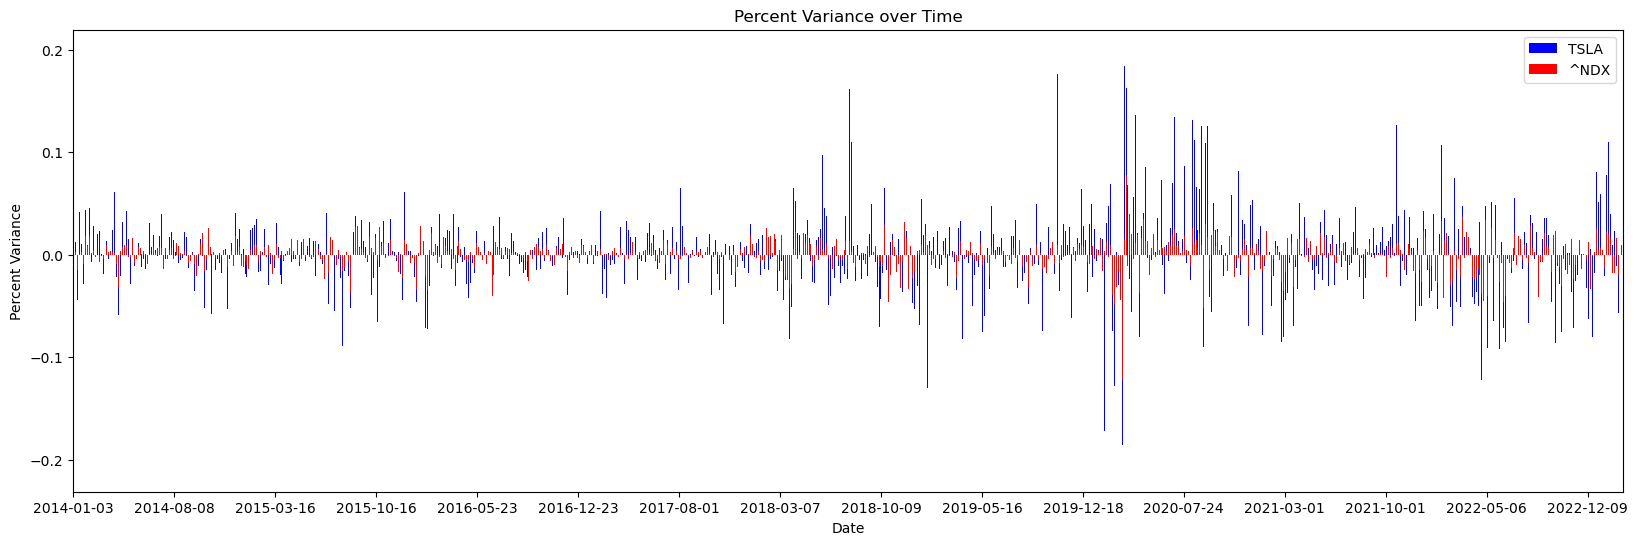

In [186]:
fig, axes = plt.subplots(1, 1, figsize=(20,6))
locs, labels = plt.xticks()

tesla.get_variance_data().plot.bar(label=tesla.get_ticker(), color = 'b')
nasdaq.get_variance_data().plot.bar(label=nasdaq.get_ticker(), color = 'r')

plt.xticks(rotation=0)
plt.legend()
plt.ylabel("Percent Variance")
plt.title("Percent Variance over Time")
locs, labels = plt.xticks()
N = 150
new_labels = [labels[::N][i].get_text()[0:10] for i in range(len(labels[::N]))]
plt.xticks(locs[::N], new_labels)
plt.show()

Since we know that Tesla is a lot more volatile compared to the nasdaq, it isn't surprising that tesla has more extreme percentage variance.



### Filtering Process

All this stock analysis and plotting so far has been building up to what we want to do, which is filter out when the Tesla's stock behavior in an anomalous manner compared to the rest of the market so that we can find a list of dates that could possibly be affect by Elon Musk's tweets. The most straightforward method to filtering would be a set threshold for anomaly detection by using the percent variance of the different stocks. Whenever Tesla's percent variance for the day is decreasing (at least -2%) while the rest of the market is either stable or increasing, we want to flag and record that date as a date of interest for later event study investigation. 

In [8]:
var_data = [stock.get_variance_data() for stock in all_list]
raw_data = [stock.get_stock_data() for stock in all_list]

name_list = [stock.get_ticker() for stock in all_list]


#
merged_frame = pd.concat(var_data, axis=1)
combined_varframe = merged_frame.set_axis(name_list, axis=1)



filtered_dates_before =[]
filtered_dates =[]


#The Date before (Only for graphing usage)
for i in range(1, len(combined_varframe)):
	row = combined_varframe[i:i+1]

	if round(row['TSLA'].values[0], 2) < -0.02 and all([round(row[str(stock.get_ticker())].values[0],2)>=0 for stock in market_list[1:]]):
		filtered_dates_before.append(str(combined_varframe[i-1:i].index[0])[0:10])

#The actual final dates when the percent variance is
for index, row in combined_varframe.iterrows():

    if round(row['TSLA'], 2) < -0.02 and all([round(row[str(stock.get_ticker())],2)>=0 for stock in market_list[1:]]):
        filtered_dates.append(str(index)[0:10])



In [9]:
ranked_years ={"2014":0, "2015":0, "2016":0, "2017":0, "2018":0, "2019":0, "2020":0, "2021":0, "2022":0, "2023":0}
for date in filtered_dates:
    year = date[0:4]
    ranked_years[year] +=1

print(ranked_years)


{'2014': 13, '2015': 12, '2016': 12, '2017': 17, '2018': 19, '2019': 18, '2020': 15, '2021': 18, '2022': 11, '2023': 0}


From this, we can see that the top 3 years that Tesla's stocks were the most volatile (without relation to the overall market) was 2018, 2019, and 2021. For scalability, we can then just focus on all the flagged dates from these 3 years. Thus, our final list of flagged dates we need to investigate is:

In [10]:
final_dates =[]
final_dates_before=[]
final_years = ["2018", "2019", "2021"]
for date in filtered_dates:
    for year in final_years:
        if date[0:4] == year:
            final_dates.append(date)

for date in filtered_dates_before:
    for year in final_years:
        if date[0:4] == year:
            final_dates_before.append(date)
print(final_dates)

['2018-04-09', '2018-04-16', '2018-05-03', '2018-05-14', '2018-05-22', '2018-06-19', '2018-06-22', '2018-07-16', '2018-07-23', '2018-08-09', '2018-08-17', '2018-09-04', '2018-09-07', '2018-09-18', '2018-09-28', '2018-10-02', '2018-11-21', '2018-12-18', '2018-12-27', '2019-01-02', '2019-01-18', '2019-01-23', '2019-02-21', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-12', '2019-03-15', '2019-04-04', '2019-04-11', '2019-04-22', '2019-04-25', '2019-04-26', '2019-05-22', '2019-06-20', '2019-10-03', '2019-11-22', '2021-01-28', '2021-02-10', '2021-03-05', '2021-03-16', '2021-03-26', '2021-04-07', '2021-04-27', '2021-04-29', '2021-05-03', '2021-05-13', '2021-06-02', '2021-07-06', '2021-07-13', '2021-08-16', '2021-11-02', '2021-11-08', '2021-11-12', '2021-11-23']


## Date Investigation (Event Study)

It starts to become clear as we begin to research happened happened relating to Tesla's stocks on those dates that not all of the dates that our filter found are connected to Elon Musk's tweets. For example, on Jan 18, 2019, one of the dates that our filter picked up, Tesla cut it's workforce by 7%.

However, it becomes clear that once we start to compare all the tweets he said on some of the flagged dates, some of the tweets which he said clearly influenced his stock prices. 

One of the clearest cases of this on Nov. 6th, 2021. On Saturday (Nov. 6th, 2021), Elon Musk made a Twitter poll saying: "Much is made lately of unrealized gains being a means of tax avoidance, so I propose selling 10% of my Tesla stock." and asked users to vote yes or no on whether he should sell his stocks. When the market opened on Monday (Nov. 8th, 2021), the stock tumbled, making Tesla lose $60 billion of its market value.

final date is: 2021-11-08


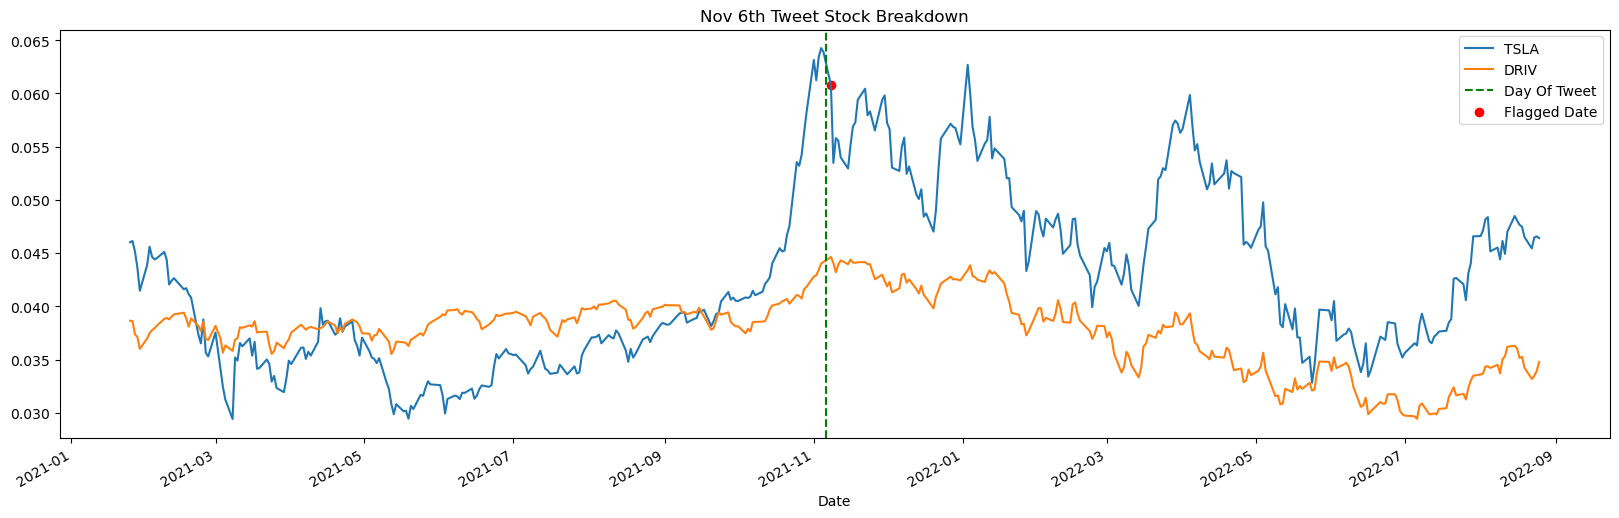

In [11]:
interesting_date =final_dates[52]

print(f"final date is: {interesting_date}")

fig, axes = plt.subplots(1, 1, figsize=(20,6))

date_range =200
tesla_ranged = tesla.get_range_date(interesting_date,range_date=date_range, type="normalized")
etf_ranged = ev_etf.get_range_date(interesting_date,range_date=date_range, type="normalized")
tesla_ranged.plot(label=tesla.get_ticker())
etf_ranged.plot(label=ev_etf.get_ticker())
plt.axvline(x="2021-11-06", linestyle='--',color="g", label="Day Of Tweet")

plt.scatter(x='2021-11-08',y=0.060765 , color="red", label="Flagged Date") 
plt.title("Nov 6th Tweet Stock Breakdown")
plt.legend()
plt.show()




## Auto Regressive Integrated Moving Averages Model (ARIMA)

In [122]:
#Separating Test & Train data
#Index 1976 is 2021-11-05

#Train Data: We're selecting all the days before the dashed line for TSLA as train data.
#Test Data: Approximately a month after the dashed line (20 data points)


train, test = train_test_split(tesla.get_normalized_data(), train_size=1976, shuffle=False)


#Use the auto_arima function built into select the best p,m,d values
auto_model = auto_arima(train, seasonal=True, m=12, D=1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)

#The number of days/data points we want to forecast into the future
predict_step =20
forecast = auto_model.predict(predict_step)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-23734.359, Time=2.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-22930.916, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-23639.311, Time=1.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-23836.202, Time=2.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-22932.980, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-23738.570, Time=1.88 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-23770.012, Time=2.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-23638.892, Time=0.73 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-23846.642, Time=2.54 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-23856.442, Time=3.90 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-23727.667, Time=4.41 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=-23851.904, Time=2.90 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-23855.504, Time=6.28 sec
 ARIMA(0,1,2)(2,1,2)[12]             : AIC=-23857.858, Time=

/home/trinity/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


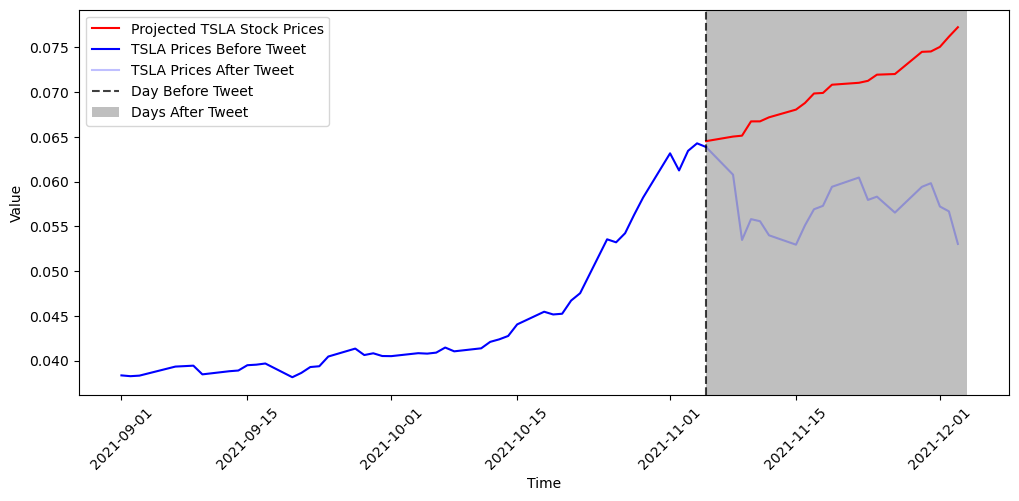

In [141]:
#Visualization


from datetime import datetime
date_object = datetime.strptime("2021-11-05", '%Y-%m-%d').date()
fig, axes = plt.subplots(1, 1, figsize=(12,5))
plt.plot(test.index[0:predict_step], forecast, c = 'red', label="Projected TSLA Stock Prices")
plt.plot(tesla.get_normalized_data()[1930:1977], c='b', label="TSLA Prices Before Tweet")
plt.plot(tesla.get_normalized_data()[1976:(1976+predict_step)], c="b", label="TSLA Prices After Tweet", alpha=0.25)
#Graphing Lines & Shaded Areas,
plt.axvline(x=date_object, linestyle='--',color="black", label="Day Before Tweet", alpha=0.75)
axes.axvspan(xmin=date_object,xmax=datetime(2021, 12, 4), facecolor='black', alpha=0.25, label="Days After Tweet")
# Set axis labels
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

